# Testing with CATBoost

In [18]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
sns.set_theme()
from catboost import CatBoostClassifier


import sys; sys.path.append("../../")
from modules.utils import load_yaml
from modules.evaluation import pretty_classification_report, plot_confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read Data

Note: in the submission, we cannot use `test.csv`. This has no labels and it is for submission only. So we need to use validation data as the test

--> This should be OK since the data size seems large enough

In [19]:
TRAIN_CONFIG_PATH = '../../config/train_config.yaml'
DATA_PATH = '../../data/01_split/'

config = load_yaml(TRAIN_CONFIG_PATH)
LABEL_ENCODING = config['LABEL_ENCODING']

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'valid.csv'))

encoding_to_label = {v: k for k, v in LABEL_ENCODING.items()}
labels = [key for key in LABEL_ENCODING.keys()]


../../config/train_config.yaml


## Split into train and test

As said, we will use val and test as the same 

In [74]:
train_X, train_y = train_df.loc[:,train_df.columns!='leaktype'], train_df['leaktype']
valid_X, valid_y = valid_df.loc[:,train_df.columns!='leaktype'], valid_df['leaktype']

train_y = train_y.replace(LABEL_ENCODING)
valid_y = valid_y.replace(LABEL_ENCODING)

# Same testing and validation
test_X, test_y = valid_X, valid_y

## Imbalanced learning

We should attempt something for the data imbalance: better check this out

NOTE: this simple trick seems to be working!

### Weights

In [4]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(5), y=train_y)

### Smote

In [6]:
# from imblearn.over_sampling import SVMSMOTE

# svmsmote = SVMSMOTE(random_state = 101)
# X_oversample_svm, y_oversample_svm = svmsmote.fit_resample(train_X, train_y)


from imblearn.over_sampling import BorderlineSMOTE
bsmote = BorderlineSMOTE(random_state = 101, kind = 'borderline-1')
X_oversample, y_oversample = bsmote.fit_resample(train_X, train_y)

# Train Model s

<!-- Tricks: we can use custom parameters to maximize the F1 score -->

Learning rate set to 0.100227
0:	learn: 0.3960663	test: 0.5649187	best: 0.5649187 (0)	total: 20.5ms	remaining: 1m 1s
200:	learn: 0.8274971	test: 0.7915916	best: 0.7921287 (199)	total: 2.93s	remaining: 40.8s
400:	learn: 0.9104289	test: 0.8512207	best: 0.8512207 (400)	total: 5.8s	remaining: 37.6s
600:	learn: 0.9454520	test: 0.8766293	best: 0.8774419 (593)	total: 8.73s	remaining: 34.8s
800:	learn: 0.9628986	test: 0.8904245	best: 0.8911709 (785)	total: 11.5s	remaining: 31.5s
1000:	learn: 0.9711574	test: 0.8988523	best: 0.8988523 (999)	total: 14.3s	remaining: 28.6s
1200:	learn: 0.9782647	test: 0.9037182	best: 0.9049098 (1195)	total: 16.8s	remaining: 25.1s
1400:	learn: 0.9826730	test: 0.9094037	best: 0.9097337 (1386)	total: 19.3s	remaining: 22s
1600:	learn: 0.9861660	test: 0.9146874	best: 0.9152062 (1573)	total: 21.8s	remaining: 19s
1800:	learn: 0.9886469	test: 0.9185894	best: 0.9185895 (1792)	total: 24.2s	remaining: 16.1s
2000:	learn: 0.9902548	test: 0.9211755	best: 0.9216750 (1972)	total: 

,precision,recall,f1-score,support
0,0.921555,0.916374,0.918957,1423
1,0.909001,0.899217,0.904083,1022
2,0.983231,0.968879,0.976002,3631
3,0.696477,0.788344,0.739568,326
4,0.711816,0.776730,0.742857,318
accuracy,0.929315,0.929315,0.929315,0
macro avg,0.844416,0.869909,0.856293,6720
weighted avg,0.932127,0.929315,0.930482,6720


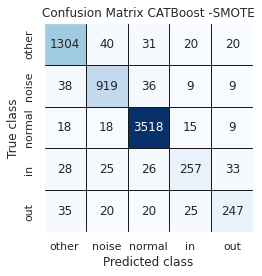

In [23]:
MODEL_NAME = 'CATBoost -SMOTE'

from imblearn.over_sampling import BorderlineSMOTE
bsmote = BorderlineSMOTE(random_state = 101, kind = 'borderline-1')
X_oversample, y_oversample = bsmote.fit_resample(train_X, train_y)

clf = CatBoostClassifier(
    iterations=3000,
    verbose=200,
    objective='MultiClass',
    eval_metric = 'TotalF1',
    custom_metric='TotalF1',
    task_type="GPU",
    # devices='0:1',
    # class_weights=class_weights
)


clf.fit(
    X_oversample, y_oversample,
    # cat_features=labels,
    eval_set=(valid_X, valid_y),
)

pred_y = clf.predict(test_X)
model_name, y_hat = MODEL_NAME, pred_y
plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

Learning rate set to 0.09072
0:	learn: 0.6259693	test: 0.6270063	best: 0.6270063 (0)	total: 17.6ms	remaining: 52.8s
200:	learn: 0.8315850	test: 0.8099599	best: 0.8099599 (200)	total: 2.49s	remaining: 34.7s
400:	learn: 0.8783684	test: 0.8490046	best: 0.8490046 (400)	total: 4.94s	remaining: 32s
600:	learn: 0.9060161	test: 0.8666025	best: 0.8667247 (597)	total: 7.28s	remaining: 29.1s
800:	learn: 0.9215308	test: 0.8780526	best: 0.8780660 (798)	total: 9.54s	remaining: 26.2s
1000:	learn: 0.9331219	test: 0.8872161	best: 0.8873960 (988)	total: 11.8s	remaining: 23.6s
1200:	learn: 0.9437493	test: 0.8920078	best: 0.8922125 (1196)	total: 14s	remaining: 21s
1400:	learn: 0.9519864	test: 0.8971324	best: 0.8971324 (1400)	total: 16.3s	remaining: 18.6s
1600:	learn: 0.9584147	test: 0.9009434	best: 0.9026888 (1570)	total: 18.5s	remaining: 16.2s
1800:	learn: 0.9646005	test: 0.9046795	best: 0.9050000 (1791)	total: 21.3s	remaining: 14.2s
2000:	learn: 0.9689619	test: 0.9084060	best: 0.9084131 (1996)	total: 23

,precision,recall,f1-score,support
0,0.932155,0.891216,0.911226,1480
1,0.897132,0.902488,0.899802,1005
2,0.994690,0.956206,0.975068,3722
3,0.574526,0.876033,0.693944,242
4,0.636888,0.815498,0.715210,271
accuracy,0.925298,0.925298,0.925298,0
macro avg,0.807078,0.888288,0.839050,6720
weighted avg,0.936767,0.925298,0.929148,6720


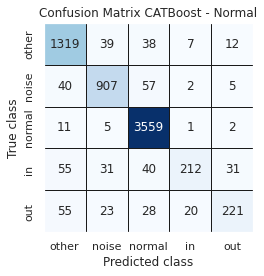

In [25]:
MODEL_NAME = 'CATBoost - Normal'

# No oversampling
X_oversample, y_oversample = train_X, train_y

clf = CatBoostClassifier(
    iterations=3000,
    verbose=200,
    objective='MultiClass',
    eval_metric = 'TotalF1',
    custom_metric='TotalF1',
    task_type="GPU",
    # devices='0:1',
    # class_weights=class_weights
)


clf.fit(
    X_oversample, y_oversample,
    # cat_features=labels,
    eval_set=(valid_X, valid_y),
)

pred_y = clf.predict(test_X)
model_name, y_hat = MODEL_NAME, pred_y
plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

Learning rate set to 0.053605
0:	learn: 0.4152779	test: 0.4043172	best: 0.4043172 (0)	total: 19.4ms	remaining: 3m 13s
200:	learn: 0.7122578	test: 0.6550094	best: 0.6571822 (198)	total: 2.68s	remaining: 2m 10s
400:	learn: 0.7991800	test: 0.7209125	best: 0.7209125 (400)	total: 5.21s	remaining: 2m 4s
600:	learn: 0.8500386	test: 0.7515268	best: 0.7526850 (566)	total: 7.97s	remaining: 2m 4s
800:	learn: 0.8823361	test: 0.7798177	best: 0.7798177 (800)	total: 10.7s	remaining: 2m 2s
1000:	learn: 0.9077892	test: 0.7932916	best: 0.7958824 (986)	total: 13.4s	remaining: 2m
1200:	learn: 0.9294773	test: 0.8012659	best: 0.8020488 (1175)	total: 16.2s	remaining: 1m 58s
1400:	learn: 0.9449939	test: 0.8102686	best: 0.8120332 (1365)	total: 19s	remaining: 1m 56s
1600:	learn: 0.9550935	test: 0.8169174	best: 0.8178277 (1587)	total: 23.7s	remaining: 2m 4s
1800:	learn: 0.9643941	test: 0.8208488	best: 0.8218504 (1765)	total: 27s	remaining: 2m 2s
2000:	learn: 0.9703124	test: 0.8256739	best: 0.8262114 (1969)	total

,precision,recall,f1-score,support
0,0.930742,0.925509,0.928118,1423
1,0.937685,0.905444,0.921283,1047
2,0.988262,0.973836,0.980996,3631
3,0.701897,0.883959,0.782477,293
4,0.746398,0.794479,0.769688,326
accuracy,0.940327,0.940327,0.940327,0
macro avg,0.860997,0.896646,0.876512,6720
weighted avg,0.943982,0.940327,0.941589,6720


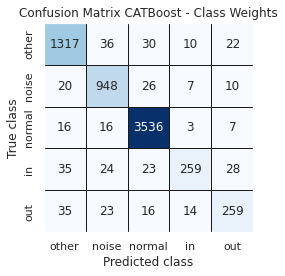

In [31]:
MODEL_NAME = 'CATBoost - Class Weights'

# No oversampling
X_oversample, y_oversample = train_X, train_y

clf = CatBoostClassifier(
    iterations=10000,
    verbose=200,
    objective='MultiClass',
    eval_metric = 'TotalF1',
    custom_metric='TotalF1',
    task_type="GPU",
    # devices='0:1',
    class_weights=class_weights
)


clf.fit(
    X_oversample, y_oversample,
    # cat_features=labels,
    eval_set=(valid_X, valid_y),
)

pred_y = clf.predict(test_X)
model_name, y_hat = MODEL_NAME, pred_y
plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

Learning rate set to 0.100222
0:	learn: 0.3975635	test: 0.5400599	best: 0.5400599 (0)	total: 20.6ms	remaining: 1m 1s
200:	learn: 0.8209411	test: 0.8274331	best: 0.8274331 (200)	total: 2.85s	remaining: 39.7s
400:	learn: 0.8987434	test: 0.8698227	best: 0.8698772 (398)	total: 5.56s	remaining: 36.1s
600:	learn: 0.9361853	test: 0.8870877	best: 0.8871565 (585)	total: 8.27s	remaining: 33s
800:	learn: 0.9558885	test: 0.8987250	best: 0.8991176 (794)	total: 10.8s	remaining: 29.6s
1000:	learn: 0.9673841	test: 0.9067270	best: 0.9072452 (976)	total: 13.3s	remaining: 26.6s
1200:	learn: 0.9748600	test: 0.9121945	best: 0.9129230 (1181)	total: 15.7s	remaining: 23.6s
1400:	learn: 0.9800753	test: 0.9173024	best: 0.9173024 (1400)	total: 18.2s	remaining: 20.8s
1600:	learn: 0.9838042	test: 0.9198860	best: 0.9209433 (1595)	total: 20.6s	remaining: 18s
1800:	learn: 0.9870197	test: 0.9233943	best: 0.9238112 (1793)	total: 23.1s	remaining: 15.4s
2000:	learn: 0.9893763	test: 0.9250956	best: 0.9252542 (1998)	total:

,precision,recall,f1-score,support
0,0.909541,0.927902,0.918630,1387
1,0.914936,0.915842,0.915388,1010
2,0.987703,0.966630,0.977053,3656
3,0.712737,0.827044,0.765648,318
4,0.757925,0.753582,0.755747,349
accuracy,0.933333,0.933333,0.933333,0
macro avg,0.856568,0.878200,0.866493,6720
weighted avg,0.935688,0.933333,0.934229,6720


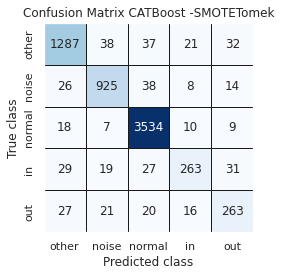

In [27]:
MODEL_NAME = 'CATBoost -SMOTETomek'

from imblearn.combine import SMOTETomek
smote = SMOTETomek(random_state = 42)
X_oversample, y_oversample = smote.fit_resample(train_X, train_y)

clf = CatBoostClassifier(
    iterations=3000,
    verbose=200,
    objective='MultiClass',
    eval_metric = 'TotalF1',
    custom_metric='TotalF1',
    task_type="GPU",
    # devices='0:1',
    # class_weights=class_weights
)


clf.fit(
    X_oversample, y_oversample,
    # cat_features=labels,
    eval_set=(valid_X, valid_y),
)

pred_y = clf.predict(test_X)
model_name, y_hat = MODEL_NAME, pred_y
plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

Learning rate set to 0.099792
0:	learn: 0.4311207	test: 0.5780457	best: 0.5780457 (0)	total: 20.3ms	remaining: 1m
200:	learn: 0.8293692	test: 0.8162233	best: 0.8162233 (200)	total: 2.75s	remaining: 38.2s
400:	learn: 0.9078303	test: 0.8580097	best: 0.8588426 (399)	total: 5.38s	remaining: 34.9s
600:	learn: 0.9473431	test: 0.8786893	best: 0.8793592 (591)	total: 8.01s	remaining: 32s
800:	learn: 0.9639955	test: 0.8882806	best: 0.8890247 (779)	total: 10.5s	remaining: 28.7s
1000:	learn: 0.9746265	test: 0.8974302	best: 0.8977900 (978)	total: 12.9s	remaining: 25.8s
1200:	learn: 0.9818944	test: 0.9028176	best: 0.9028565 (1179)	total: 15.4s	remaining: 23.1s
1400:	learn: 0.9863828	test: 0.9082327	best: 0.9082327 (1399)	total: 18.1s	remaining: 20.6s
1600:	learn: 0.9896971	test: 0.9139588	best: 0.9139588 (1600)	total: 21s	remaining: 18.3s
1800:	learn: 0.9923015	test: 0.9151966	best: 0.9159301 (1769)	total: 24.2s	remaining: 16.1s
2000:	learn: 0.9941821	test: 0.9173776	best: 0.9179550 (1995)	total: 27

,precision,recall,f1-score,support
0,0.903887,0.919482,0.911618,1391
1,0.916914,0.894788,0.905716,1036
2,0.974287,0.968602,0.971437,3599
3,0.715447,0.774194,0.743662,341
4,0.740634,0.728045,0.734286,353
accuracy,0.924554,0.924554,0.924554,0
macro avg,0.850234,0.857022,0.853344,6720
weighted avg,0.925461,0.924554,0.924907,6720


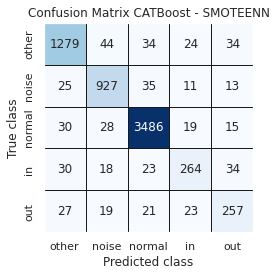

In [28]:
MODEL_NAME = 'CATBoost - SMOTEENN'

from imblearn.combine import SMOTEENN
smote = SMOTEENN(random_state = 42)
X_oversample, y_oversample = smote.fit_resample(train_X, train_y)

clf = CatBoostClassifier(
    iterations=3000,
    verbose=200,
    objective='MultiClass',
    eval_metric = 'TotalF1',
    custom_metric='TotalF1',
    task_type="GPU",
    # devices='0:1',
    # class_weights=class_weights
)


clf.fit(
    X_oversample, y_oversample,
    # cat_features=labels,
    eval_set=(valid_X, valid_y),
)

pred_y = clf.predict(test_X)
model_name, y_hat = MODEL_NAME, pred_y
plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

Learning rate set to 0.059223
0:	learn: 0.3983525	test: 0.5384148	best: 0.5384148 (0)	total: 21ms	remaining: 3m 30s
200:	learn: 0.7608419	test: 0.7929679	best: 0.7929679 (200)	total: 2.87s	remaining: 2m 19s
400:	learn: 0.8460245	test: 0.8439659	best: 0.8439659 (400)	total: 5.6s	remaining: 2m 14s
600:	learn: 0.8902068	test: 0.8664640	best: 0.8668964 (595)	total: 8.28s	remaining: 2m 9s
800:	learn: 0.9180553	test: 0.8804744	best: 0.8813116 (794)	total: 10.9s	remaining: 2m 5s
1000:	learn: 0.9365019	test: 0.8910432	best: 0.8918090 (992)	total: 13.5s	remaining: 2m 1s
1200:	learn: 0.9498989	test: 0.8956536	best: 0.8961039 (1147)	total: 16.1s	remaining: 1m 57s
1400:	learn: 0.9586535	test: 0.9026784	best: 0.9031445 (1397)	total: 18.6s	remaining: 1m 53s
1600:	learn: 0.9658695	test: 0.9072814	best: 0.9075420 (1590)	total: 21.1s	remaining: 1m 50s
1800:	learn: 0.9710246	test: 0.9108857	best: 0.9109126 (1799)	total: 23.6s	remaining: 1m 47s
2000:	learn: 0.9752090	test: 0.9142075	best: 0.9147836 (1995

,precision,recall,f1-score,support
0,0.933569,0.934229,0.933899,1414
1,0.924827,0.920276,0.922546,1016
2,0.989380,0.970661,0.979931,3647
3,0.718157,0.841270,0.774854,315
4,0.752161,0.795732,0.773333,328
accuracy,0.940774,0.940774,0.940774,0
macro avg,0.863619,0.892433,0.876912,6720
weighted avg,0.943584,0.940774,0.941872,6720


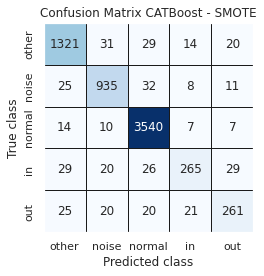

In [32]:
MODEL_NAME = 'CATBoost - SMOTE'

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_oversample, y_oversample = smote.fit_resample(train_X, train_y)

clf = CatBoostClassifier(
    iterations=10000,
    verbose=200,
    objective='MultiClass',
    eval_metric = 'TotalF1',
    custom_metric='TotalF1',
    task_type="GPU",
    # devices='0:1',
    # class_weights=class_weights
)


clf.fit(
    X_oversample, y_oversample,
    # cat_features=labels,
    eval_set=(valid_X, valid_y),
)

pred_y = clf.predict(test_X)
model_name, y_hat = MODEL_NAME, pred_y
plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

Learning rate set to 0.060563
0:	learn: 0.4323255	test: 0.5932066	best: 0.5932066 (0)	total: 21.5ms	remaining: 3m 34s
200:	learn: 0.7621192	test: 0.8203105	best: 0.8203105 (200)	total: 3.03s	remaining: 2m 27s
400:	learn: 0.8406815	test: 0.8729819	best: 0.8736354 (397)	total: 5.87s	remaining: 2m 20s
600:	learn: 0.8830539	test: 0.9005920	best: 0.9007490 (592)	total: 8.69s	remaining: 2m 15s
800:	learn: 0.9126826	test: 0.9198432	best: 0.9198591 (799)	total: 11.5s	remaining: 2m 12s
1000:	learn: 0.9324421	test: 0.9346800	best: 0.9348255 (996)	total: 14.4s	remaining: 2m 9s
1200:	learn: 0.9452397	test: 0.9460082	best: 0.9460082 (1200)	total: 17.5s	remaining: 2m 8s
1400:	learn: 0.9546221	test: 0.9525279	best: 0.9525279 (1400)	total: 20.3s	remaining: 2m 4s
1600:	learn: 0.9614977	test: 0.9595053	best: 0.9595053 (1598)	total: 23s	remaining: 2m
1800:	learn: 0.9674170	test: 0.9641204	best: 0.9642637 (1796)	total: 25.9s	remaining: 1m 58s
2000:	learn: 0.9722243	test: 0.9682982	best: 0.9684453 (1995)	t

,precision,recall,f1-score,support
0,0.997880,1.000000,0.998939,1412
1,0.998022,1.000000,0.999010,1009
2,1.000000,0.998605,0.999302,3583
3,1.000000,1.000000,1.000000,369
4,1.000000,1.000000,1.000000,347
accuracy,0.999256,0.999256,0.999256,0
macro avg,0.999180,0.999721,0.999450,6720
weighted avg,0.999257,0.999256,0.999256,6720


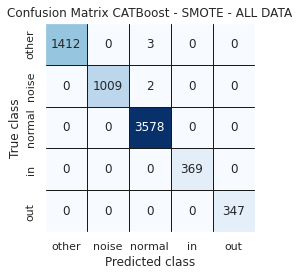

In [45]:
MODEL_NAME = 'CATBoost - SMOTE - ALL DATA'

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)

total_train_X, total_train_y =  pd.concat([train_X, valid_X], ignore_index=True), pd.concat([train_y, valid_y], ignore_index=True)
X_oversample, y_oversample = smote.fit_resample(total_train_X, total_train_y)

clf = CatBoostClassifier(
    iterations=30000,
    verbose=200,
    objective='MultiClass',
    eval_metric = 'TotalF1',
    custom_metric='TotalF1',
    task_type="GPU",
    # devices='0:1',
    # class_weights=class_weights
)

clf.fit(
    X_oversample, y_oversample,
    # cat_features=labels,
    eval_set=(valid_X, valid_y),
)

pred_y = clf.predict(test_X)
model_name, y_hat = MODEL_NAME, pred_y
plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

F1 score : 0.976


,precision,recall,f1-score,support
0,0.971025,0.989201,0.980029,1389
1,0.968348,0.973161,0.970749,1006
2,0.996926,0.989734,0.993317,3604
3,0.962060,0.959459,0.960758,370
4,0.979827,0.968661,0.974212,351
accuracy,0.984375,0.984375,0.984375,0
macro avg,0.975637,0.976043,0.975813,6720
weighted avg,0.984481,0.984375,0.984401,6720


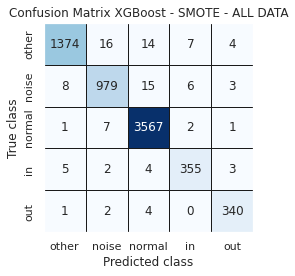

In [93]:
MODEL_NAME = 'XGBoost - SMOTE - ALL DATA'

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)

total_train_X, total_train_y =  pd.concat([train_X, valid_X], ignore_index=True), pd.concat([train_y, valid_y], ignore_index=True)
X_oversample, y_oversample = smote.fit_resample(total_train_X, total_train_y)

clf = XGBClassifier(
)

clf.fit(
    X_oversample, y_oversample,
    # eval_set=[valid_X, valid_y],
    verbose=True,
)

pred_y = clf.predict(test_X)
model_name, y_hat = MODEL_NAME, pred_y
plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

F1 score : 0.826


,precision,recall,f1-score,support
0,0.876325,0.919199,0.897250,1349
1,0.878338,0.879208,0.878773,1010
2,0.982392,0.960383,0.971263,3660
3,0.647696,0.690751,0.668531,346
4,0.720461,0.704225,0.712251,355
accuracy,0.912500,0.912500,0.912500,0
macro avg,0.821043,0.830753,0.825614,6720
weighted avg,0.914391,0.912500,0.913234,6720


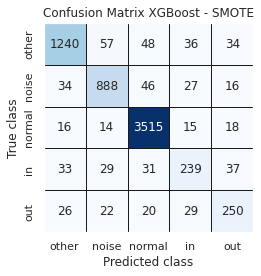

In [96]:
MODEL_NAME = 'XGBoost - SMOTE'

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)

X_oversample, y_oversample = smote.fit_resample(train_X, train_y)

clf = XGBClassifier(
)

clf.fit(
    X_oversample, y_oversample,
    # eval_set=[valid_X, valid_y],
    verbose=True,
)

pred_y = clf.predict(test_X)
model_name, y_hat = MODEL_NAME, pred_y
plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

Learning rate set to 0.059223
0:	learn: 0.3983525	test: 0.5384148	best: 0.5384148 (0)	total: 21.3ms	remaining: 3m 33s
200:	learn: 0.7583101	test: 0.7920588	best: 0.7920588 (200)	total: 2.84s	remaining: 2m 18s
400:	learn: 0.8474754	test: 0.8439787	best: 0.8440138 (399)	total: 5.68s	remaining: 2m 15s
600:	learn: 0.8920009	test: 0.8682168	best: 0.8685676 (599)	total: 8.3s	remaining: 2m 9s
800:	learn: 0.9197171	test: 0.8815424	best: 0.8820543 (796)	total: 10.9s	remaining: 2m 4s
1000:	learn: 0.9377701	test: 0.8894901	best: 0.8894901 (1000)	total: 13.4s	remaining: 2m
1200:	learn: 0.9505832	test: 0.8982451	best: 0.8982451 (1200)	total: 15.9s	remaining: 1m 56s
1400:	learn: 0.9599172	test: 0.9060846	best: 0.9060846 (1400)	total: 18.3s	remaining: 1m 52s
1600:	learn: 0.9662431	test: 0.9091327	best: 0.9098421 (1585)	total: 20.7s	remaining: 1m 48s
1800:	learn: 0.9707172	test: 0.9144374	best: 0.9145920 (1792)	total: 23.1s	remaining: 1m 45s
2000:	learn: 0.9742961	test: 0.9161962	best: 0.9163286 (1995

,precision,recall,f1-score,support
0,0.926502,0.937768,0.932101,1398
1,0.923838,0.918387,0.921105,1017
2,0.990777,0.968050,0.979282,3662
3,0.710027,0.839744,0.769457,312
4,0.772334,0.809668,0.790560,331
accuracy,0.940476,0.940476,0.940476,0
macro avg,0.864696,0.894723,0.878501,6720
weighted avg,0.943480,0.940476,0.941624,6720


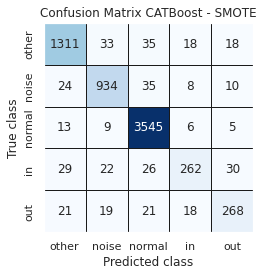

In [95]:
MODEL_NAME = 'CATBoost - SMOTE'

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_oversample, y_oversample = smote.fit_resample(train_X, train_y)

clf = CatBoostClassifier(
    iterations=10000,
    verbose=200,
    objective='MultiClass',
    eval_metric = 'TotalF1',
    custom_metric='TotalF1',
    task_type="GPU",
    # devices='0:1',
    # class_weights=class_weights
)


clf.fit(
    X_oversample, y_oversample,
    # cat_features=labels,
    eval_set=(valid_X, valid_y),
)

pred_y = clf.predict(test_X)
model_name, y_hat = MODEL_NAME, pred_y
plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

Text(0.5, 1.0, 'Feature Importance')

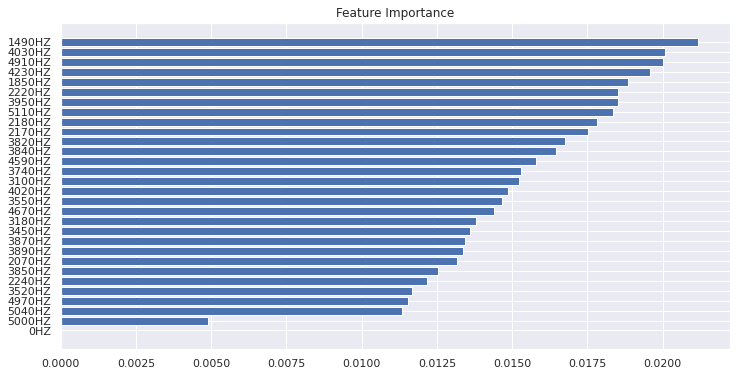

In [59]:

feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)[:30]
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test_X.columns)[sorted_idx])
# plt.yticks([])
plt.title('Feature Importance')


# Prediction

In [47]:
pred_y = clf.predict(test_X)

# Metrics evaluation

We need to get a few metrics right

F1 score : 0.999


,precision,recall,f1-score,support
0,0.997880,1.000000,0.998939,1412
1,0.998022,1.000000,0.999010,1009
2,1.000000,0.998605,0.999302,3583
3,1.000000,1.000000,1.000000,369
4,1.000000,1.000000,1.000000,347
accuracy,0.999256,0.999256,0.999256,0
macro avg,0.999180,0.999721,0.999450,6720
weighted avg,0.999257,0.999256,0.999256,6720


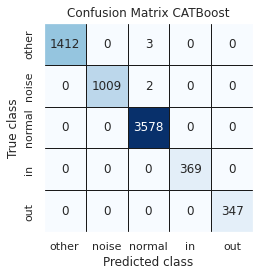

In [48]:
model_name, y_hat = 'CATBoost', pred_y

plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

## Actual test for submission

In [51]:
# Setup
model = clf
LABEL_DECODING = {y:x for x,y in LABEL_ENCODING.items()}
RESULTS_PATH = '.'
DATA_DIR = '../../data/01_split'
SAMPLE_DIR = '../../data/sample_submission.csv'


test_df = pd.read_csv(os.path.join(DATA_DIR,'test.csv'))
test_X = test_df.loc[:,test_df.columns!='id']
test_ids = test_df['id']


# Make predictions
sample_df = pd.read_csv(SAMPLE_DIR)
sorter = list(sample_df['id'])

y_pred = model.predict(test_X)
y_pred_df = pd.DataFrame(y_pred, columns=['leaktype'])
y_pred_df['leaktype'] = y_pred_df['leaktype'].replace(LABEL_DECODING)
pred_df = pd.concat([test_ids, y_pred_df],axis=1)

# sort predictions
resdf = pred_df.set_index('id')
result = resdf.loc[sorter].reset_index()
resultpath = os.path.join(RESULTS_PATH, 'predictions.csv')
result.to_csv(resultpath, index=False)